<a href="https://colab.research.google.com/github/EmilyBoland/Syntaxin-EESM-Analysis/blob/master/Cleaned_work_analysis_with_thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accessing, Importing, and Tallying Data



Give Access to Drive and Import Packages/Functions/Data



In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import entropy
import json
import sys
import matplotlib.gridspec as gridspec

sys.path.append('/content/drive/My Drive/Kasson lab/Polished Syntaxin Code')
import work_analysis_functions as waf

alldata = json.load(open('cleaned-uniform-0.5nm/all_data_for_eb.json'))
finaldata = json.load(open('Kasson lab/Polished Syntaxin Code/final_ensemble.json'))


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive




Create Dictionaries to Keep Track of Data



In [2]:
# target_to_mem_dict connects targets to members = {'d1,d2,d3': [mem_n], 'd1,d2,d3': [mem_i, mem_j],...}
# mem_to_target-dict connects members to targets = {'mem_n': 'd1,d2,d3',...}
# run_tally counts the number of runs per target set = {target set: number of runs, target set: ...}
# missing_runs connects a list simulation runs that were never initiated to a target set. There should be ten runs per member = {target_set:[runi, runj], target_set:...}
# complete_runs connects a list of simulation runs that were intiated to each target set {target_set:[runi, runj], target_set:...}

target_dict = alldata['targets']

target_to_mem_dict = {}
mem_to_target_dict = {}
for mem in target_dict: 
  target_set = str(target_dict[mem]['052_210']) + ',' + str(target_dict[mem]['105_216']) + ',' + str(target_dict[mem]['196_228'])
  if target_set in target_to_mem_dict.keys():
    target_to_mem_dict[target_set].append(mem)
  else: 
    target_to_mem_dict[target_set] = [mem]
  mem_to_target_dict[mem] = target_set


run_tally = {}
for target in target_to_mem_dict: 
  tally = 0
  for mem in target_to_mem_dict[target]:
    tally += len(alldata['initial states'][mem])
  run_tally[target] = tally 


missing_runs = {}
for mem in alldata['initial states']:
  for run in range(1,11):
    try:
      a = alldata['initial states'][mem][str(run)]
    except: 
      target_set = mem_to_target_dict[mem]
      if target_set in missing_runs.keys(): 
        missing_runs[target_set].append(run)
      else: 
        missing_runs[target_set] = [run]


completed_runs = {}
for mem in alldata['initial states']: 
  target_set = mem_to_target_dict[mem]
  completed_runs[target_set] = []
  for run in alldata['initial states'][mem]:
    completed_runs[target_set].append(int(run))


# Calculating Work and Obtaining Probabilities



Calculate and Threshold Work



In [3]:
# work_values contains all work values for a given target set: {"d1,d2,d3":[w1,w2,...],...}
# work_values_by_run contains all work values for a single run for a given target set: {run: {"d1,d2,d3":[w1,w2,...],...}, ...} for converged runs only

work_values = {}
work_values_by_run = {1:{},2:{},3:{},4:{},5:{},6:{},7:{},8:{},9:{},10:{}}
  
for mem in alldata['converged run data']:
  for run in alldata['converged run data'][mem]:
    key = str(alldata['converged run data'][mem][run]["052_210"]['target'])+','+str(alldata['converged run data'][mem][run]["105_216"]['target'])+','+str(alldata['converged run data'][mem][run]["196_228"]['target'])
    work = waf.calc_work(alldata, mem, run)
    
    if key in work_values.keys():
      work_values[key].append(work)
    else: 
      work_values[key] = [work]

    if key in work_values_by_run[int(run)].keys():
      work_values_by_run[int(run)][key].append(work)
    else: 
      work_values_by_run[int(run)][key] = [work]
    

threshold_val = 400
thresholded_data = waf.threshold(threshold_val, work_values, work_values_by_run)
work_values = thresholded_data['work_values']
work_values_by_run = thresholded_data['work_values_by_run']



Account for nonconverged runs 



In [4]:
# adds in infinite work values for unconverged runs as string 'INF'
  # work_values is formatted the same, but the values (lists of work estimate calculations) will have length multiple of 10

for target_set in target_to_mem_dict:
  if target_set not in work_values.keys():
    work_values[target_set] = ['INF']

for target_set in work_values: 
  num_runs = len(completed_runs[target_set])
  for run in range(num_runs-len(work_values[target_set])):
    work_values[target_set].append('INF')


Create Work Dictionaries with Cumulative Work Values



In [5]:
# creates 1 dictionary with work calculations through runs (cumulative): 
  # work_values_through_trials contains all work values (including infinite work) for all runs up to and including the key run: {run: {"d1,d2,d3":[w1,w2,...],...}, ...}
    # ex: work_values_through_trials[5]["d1,d2,d3"] contains the work values from runs 1-5 where the target set was "d1,d2,d3"

work_values_through_runs = {1:{},2:{},3:{},4:{},5:{},6:{},7:{},8:{},9:{},10:{}}

for target_set in completed_runs: 
  for run in range(1,11):
    work_values_through_runs[run][target_set] = []
    for comp_run in completed_runs[target_set]:
      if comp_run <= run: 
        if target_set in work_values_by_run[comp_run].keys():
          work_values_through_runs[run][target_set] += work_values_by_run[comp_run][target_set]
        else: 
          work_values_through_runs[run][target_set].append("INF")




Implement Jarzynski Equation



In [6]:
# implements Jarzynski Equation on all runs to all runs of all target sets to find average e^(-beta*W) = e^(-beta*deltaG)

jarz_work_dict = {}
for target_set in work_values: 
  w_vals = work_values[target_set]
  jarz_work = waf.average_jarz_work(w_vals)
  jarz_work_dict[target_set] = jarz_work


# implements Jarzynski Equation to find average exponential work through trials

jarz_work_through_runs = {1:{},2:{},3:{},4:{},5:{},6:{},7:{},8:{},9:{},10:{}}
for run in jarz_work_through_runs:
  for target_set in work_values_through_runs[run]:
    w_vals = work_values_through_runs[run][target_set]
    exp_work = waf.average_jarz_work(w_vals)
    jarz_work_through_runs[run][target_set] = exp_work




Normalize Probabilities



In [7]:
normalized_probs = waf.normalize_probs(jarz_work_dict)

probs_through_runs = {}
for run in jarz_work_through_runs: 
  probs_through_runs[run] = waf.normalize_probs(jarz_work_through_runs[run])


# Generating 2D Figures



Reformat and Plot Experimental Data



True

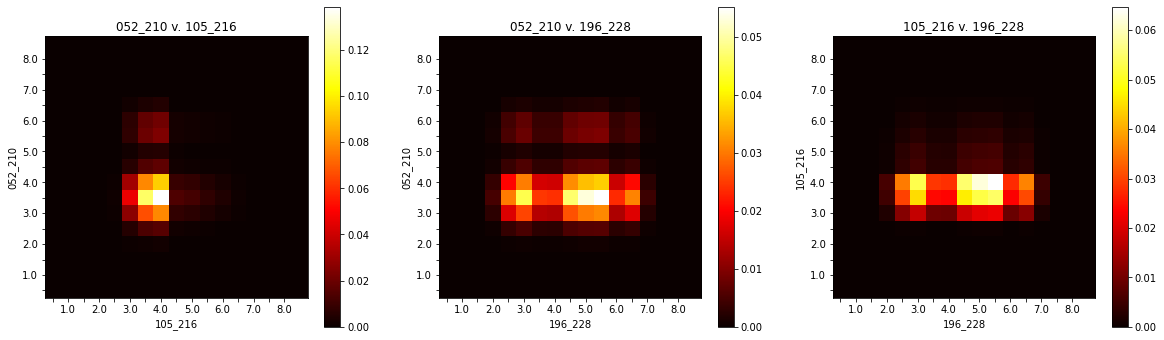

In [8]:
# this code is adapted from Jennifer Hays Wagner

exp_data = alldata['experimental data']
bins = exp_data["052_210"]["bins"]
nbins = len(bins) 

exp052_210 = waf.normalize_probs(exp_data["052_210"]["distribution"])
exp105_216 = waf.normalize_probs(exp_data["105_216"]["distribution"])
exp196_228 = waf.normalize_probs(exp_data["196_228"]["distribution"])

joint_exp = np.zeros(shape=(nbins, nbins, nbins))
for i in range(nbins):
  for j in range(nbins):
    for k in range(nbins):
      joint_exp[i,j,k] = exp052_210[i] * \
      exp105_216[j] * \
      exp196_228[k]

np.testing.assert_almost_equal(np.sum(joint_exp), 1)

exp_2D_dict = waf.twoD_sum(joint_exp)
exp_1D_dict = waf.oneD_sum(joint_exp)

waf.make_map(exp_2D_dict)




Create Figures to Visualize Starting Conformations



True

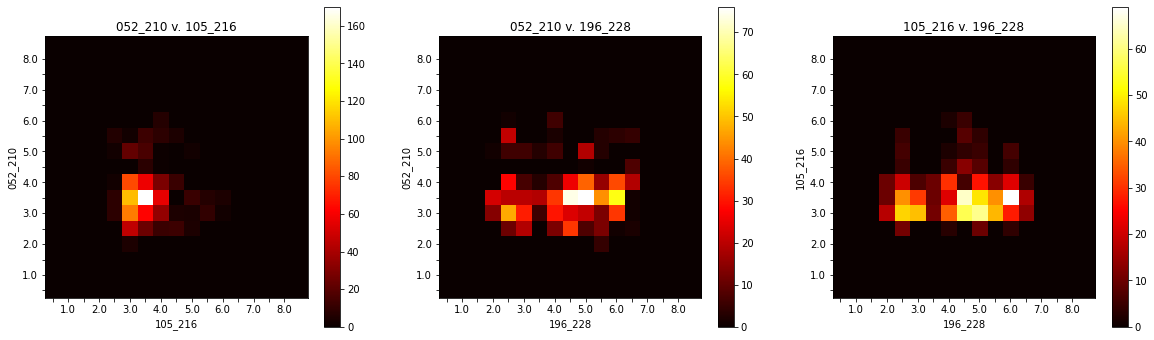

In [9]:
start_dict = alldata['initial states']

starting_confs = np.zeros(shape = (nbins,nbins,nbins))

for mem in start_dict: 
  for run in start_dict[mem]:
    try:
      starting_confs[np.digitize((start_dict[mem][run]['052_210']),bins)-1,np.digitize((start_dict[mem][run]['105_216']),bins)-1,np.digitize((start_dict[mem][run]['196_228']),bins)-1] += 1
    except: 
      print("we have and error with {}, run {}: {}".format(mem, run, start_dict[mem][run]))

start_2D_dict = waf.twoD_sum(starting_confs)
waf.make_map(start_2D_dict)

Creates Figures to Visualize Target Conformations

{'mem_1': {'052_210': 7.0, '105_216': 0.5, '196_228': 3.0}, 'mem_2': {'052_210': 5.5, '105_216': 1.0, '196_228': 1.0}, 'mem_3': {'052_210': 2.5, '105_216': 4.5, '196_228': 1.0}, 'mem_4': {'052_210': 3.5, '105_216': 5.0, '196_228': 6.0}, 'mem_5': {'052_210': 6.0, '105_216': 5.0, '196_228': 5.5}, 'mem_6': {'052_210': 2.0, '105_216': 3.0, '196_228': 6.0}, 'mem_7': {'052_210': 6.0, '105_216': 7.0, '196_228': 6.5}, 'mem_8': {'052_210': 6.5, '105_216': 2.5, '196_228': 4.5}, 'mem_9': {'052_210': 4.5, '105_216': 3.5, '196_228': 3.0}, 'mem_10': {'052_210': 3.0, '105_216': 1.5, '196_228': 1.0}, 'mem_11': {'052_210': 1.5, '105_216': 4.5, '196_228': 4.0}, 'mem_12': {'052_210': 5.5, '105_216': 7.0, '196_228': 4.0}, 'mem_13': {'052_210': 2.5, '105_216': 0.5, '196_228': 6.5}, 'mem_14': {'052_210': 3.5, '105_216': 3.0, '196_228': 6.5}, 'mem_15': {'052_210': 6.0, '105_216': 3.5, '196_228': 7.0}, 'mem_16': {'052_210': 5.5, '105_216': 5.5, '196_228': 4.0}, 'mem_17': {'052_210': 2.0, '105_216': 5.0, '196_

True

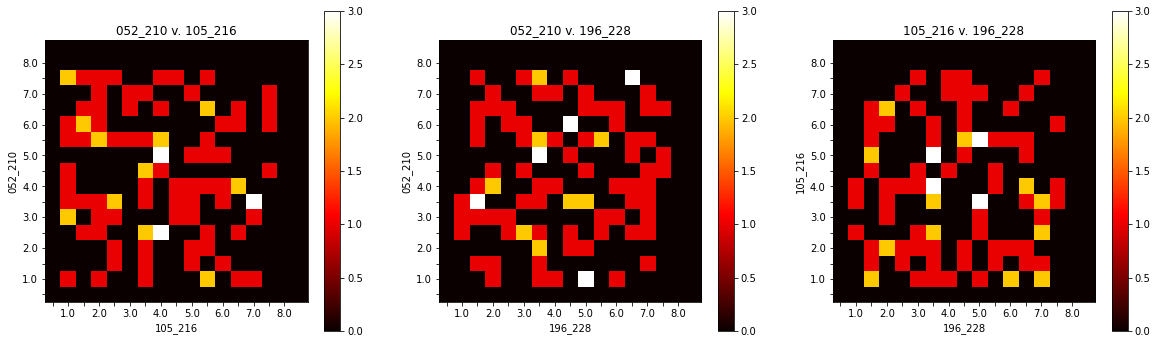

In [10]:
target_dict = alldata['targets']
print(target_dict)
target_confs = np.zeros(shape = (nbins, nbins, nbins))
for mem in target_dict: 
  target_confs[bins.index(target_dict[mem]['052_210']),bins.index(target_dict[mem]['105_216']),bins.index(target_dict[mem]['196_228'])] += 1

target_2D_dict = waf.twoD_sum(target_confs)
waf.make_map(target_2D_dict)

Plot Simulation Data

True

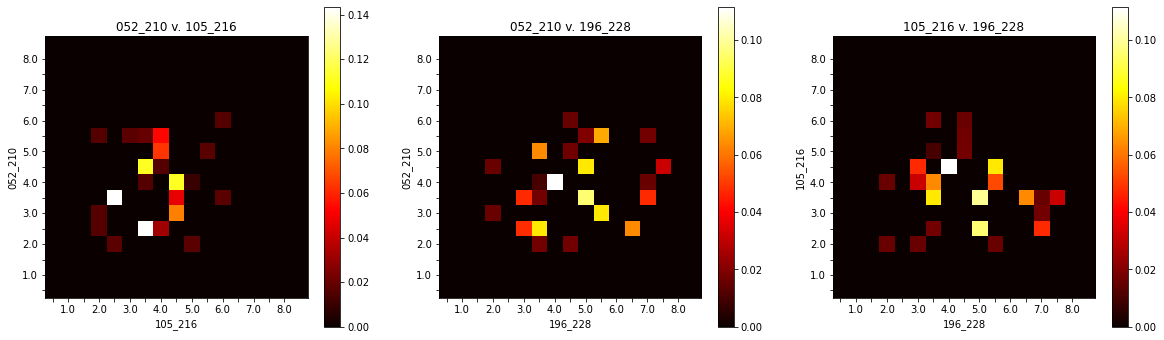

In [11]:
simdata = np.zeros(shape=(nbins,nbins,nbins))
for key in normalized_probs:   
  simdata[bins.index(float(key[0:3])), bins.index(float(key[4:7])), bins.index(float(key[8:11]))] += normalized_probs[key]

sim_2D_dict = waf.twoD_sum(simdata)
sim_1D_dict = waf.oneD_sum(simdata)

waf.make_map(sim_2D_dict)

# Generating 1D Figures

Plot 1D Projections of Simulation and Experimental Data

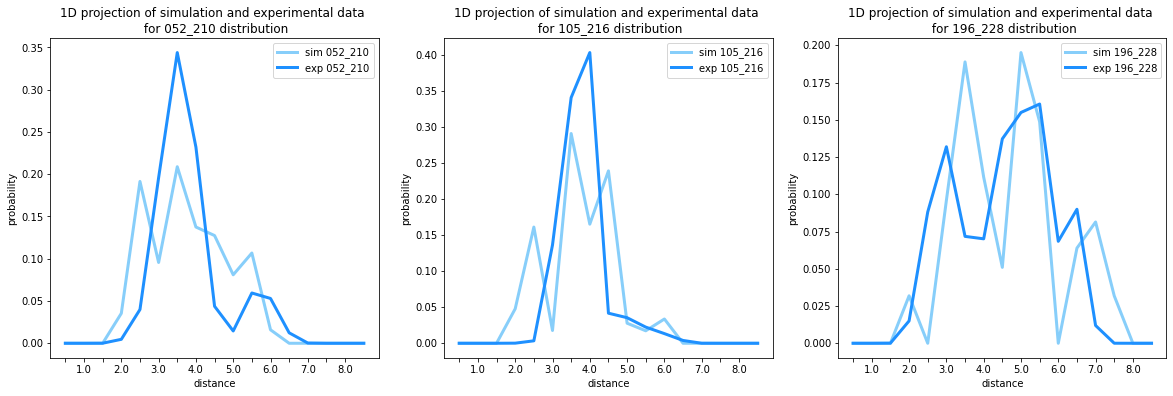

In [12]:
fig = plt.figure(figsize = (20,20))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure = fig, wspace = 0.5)
i = 1
for key in sim_1D_dict: 
  fig.add_subplot(3,3,i)
  plt.plot(sim_1D_dict[key], 'lightskyblue', lw = 3)
  plt.plot(exp_1D_dict[key], 'dodgerblue', lw = 3)
  plt.xlabel("distance")
  plt.ylabel("probability") 
  plt.title("1D projection of simulation and experimental data \n for {} distribution".format(key, threshold_val))
  plt.xticks(np.arange(16), ('','1.0', '','2.0', '','3.0','', '4.0','', '5.0','','6.0','','7.0','','8.0'));
  plt.legend(['sim {}'.format(key), 'exp {}'.format(key)])
  i += 1


# Generating JS Divergence Figures

Plot JS Divergence Along Each Distribution

Text(0.5, 1.0, 'JS-Divergence Between Experimental and Simulation Data')

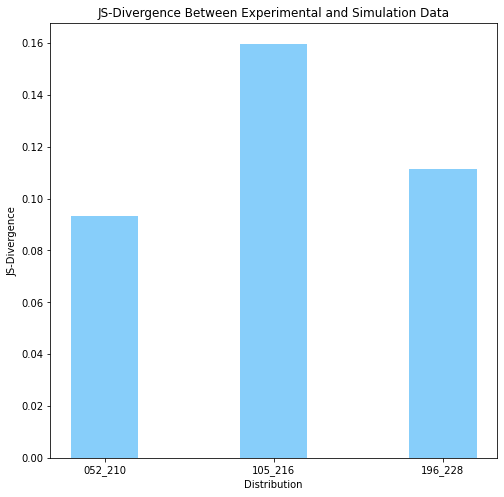

In [41]:
sim_v_exp_div052_210 = waf.JScalculator(sim_1D_dict['052_210'],exp_1D_dict['052_210'])
sim_v_exp_div105_216 = waf.JScalculator(sim_1D_dict['105_216'],exp_1D_dict['105_216'])
sim_v_exp_div196_228 = waf.JScalculator(sim_1D_dict['196_228'],exp_1D_dict['196_228'])
# %pylab inline
# figsize(10, 10)
# fig = figure(figsize = (10, 10)) <- I may be wrong here
fig = plt.figure(figsize = (8,8))
plt.bar([1,2,3],[sim_v_exp_div052_210,sim_v_exp_div105_216,sim_v_exp_div196_228],  width = 0.4, tick_label = ["052_210","105_216","196_228"], color = 'lightskyblue')
plt.xlabel("Distribution")
plt.ylabel("JS-Divergence")
plt.title("JS-Divergence Between Experimental and Simulation Data")

Plot JS Divergence Along Runs (Cumulative)

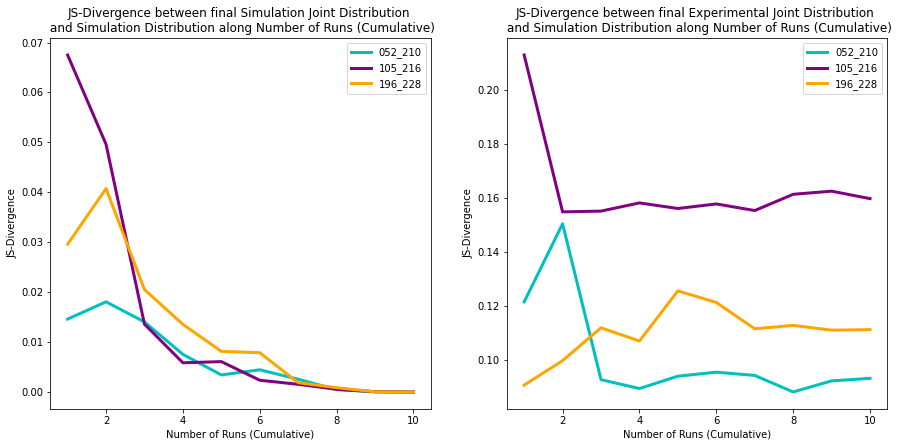

In [14]:
sim_data_by_run = {}
for run in range(1,11):
  sim_data_by_run[run] = np.zeros(shape=(nbins,nbins,nbins))
  for key in probs_through_runs[run]:   
    sim_data_by_run[run][bins.index(float(key[0:3])), bins.index(float(key[4:7])), bins.index(float(key[8:11]))] += probs_through_runs[run][key]
  
sim_data_1D_by_run = {'052_210':{}, '105_216': {}, '196_228':{}}
for run in sim_data_by_run:
  sim_data_1D_by_run['052_210'][run] = np.sum(sim_data_by_run[run], axis =(1,2))
  sim_data_1D_by_run['105_216'][run] = np.sum(sim_data_by_run[run], axis =(0,2))
  sim_data_1D_by_run['196_228'][run] = np.sum(sim_data_by_run[run], axis =(0,1))
  
fig = plt.figure(figsize = (15,15))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure = fig, wspace = 0.5)
fig.add_subplot(2,2,1)
waf.plot_js_along_runs(sim_data_1D_by_run, sim_1D_dict, "Simulation")
fig.add_subplot(2,2,2)
waf.plot_js_along_runs(sim_data_1D_by_run, exp_1D_dict,"Experimental")


# Addition of two new distributions

Create List of all Members and Runs that Converged

In [15]:
work_by_mem = {}
for mem in alldata['converged run data']:
  work_by_mem[mem] = {}
  for run in alldata['converged run data'][mem]:
    work = waf.calc_work(alldata, mem, run)
    work_by_mem[mem][run] = work

ws_above_threshold = {}
for mem in work_by_mem:
  for run in work_by_mem[mem]:
    if work_by_mem[mem][run] > threshold_val:
      if mem in ws_above_threshold.keys():
        ws_above_threshold[mem].append(run)
      else: 
        ws_above_threshold[mem] = [run]

print(ws_above_threshold)


{'mem_98': ['3', '4', '5', '8', '9'], 'mem_23': ['3', '5', '7', '9'], 'mem_93': ['3', '4', '5', '6', '7', '8', '9'], 'mem_33': ['1', '2', '3', '4', '5', '6', '7', '8', '9'], 'mem_96': ['1', '3', '4', '7', '8'], 'mem_57': ['1', '2', '3', '4', '7', '8'], 'mem_20': ['1', '2', '3', '4', '5', '6', '7', '9'], 'mem_18': ['1', '2', '3', '7'], 'mem_6': ['3', '5', '6', '7', '8'], 'mem_38': ['1', '2', '3', '4', '5', '6', '7', '8', '9'], 'mem_75': ['3', '4', '6', '8'], 'mem_14': ['2', '3', '4', '5', '7', '9'], 'mem_66': ['1', '2', '3', '4', '7', '8', '9'], 'mem_11': ['5'], 'mem_8': ['1'], 'mem_4': ['1', '2', '3', '4', '5', '6', '7', '8', '9'], 'mem_73': ['5', '7'], 'mem_49': ['1', '2', '3', '4', '5', '6', '7', '9'], 'mem_76': ['5', '6'], 'mem_61': ['1', '2', '3', '5', '7', '8', '9'], 'mem_99': ['2'], 'mem_13': ['1', '2', '3', '4', '5', '6', '7', '8', '9'], 'mem_24': ['2', '3', '4'], 'mem_88': ['1'], 'mem_28': ['1', '2'], 'mem_83': ['1', '2'], 'mem_48': ['3', '4', '5', '6', '7', '8', '9'], 'mem_78'

Assign Probabilities to 5 dimensional target sets

In [16]:
fiveD_probs = {}
missing = {}

for mem in ws_above_threshold:
  for run in ws_above_threshold[mem]:
    prob = normalized_probs[mem_to_target_dict[mem]]
    try:
      d1, d2, d3 = alldata['targets'][mem]['052_210'], alldata['targets'][mem]['105_216'], alldata['targets'][mem]['196_228']
      d4, d5 = bins[np.digitize((finaldata[mem][run]['105_225']),bins)-1], bins[np.digitize((finaldata[mem][run]['151_196']),bins)-1]
      target_set = str(d1)+','+str(d2)+','+str(d3)+','+str(d4)+','+str(d5)
      if target_set in fiveD_probs.keys():
        fiveD_probs[target_set] += prob
      else:
        fiveD_probs[target_set] = prob
    except:
      if mem in missing.keys():
        missing[mem].append(run)
      else:
        missing[mem] = [run]

fiveD_probs = waf.normalize_probs(fiveD_probs)


Reformat Probabilities from Dictionary to Array and Sum to Obtain 1D Probability Distributions for new Distributions

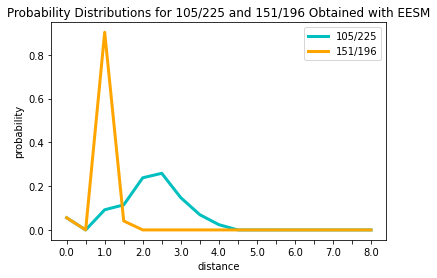

In [17]:
fiveD_confs = np.zeros(shape = (nbins,nbins,nbins,nbins,nbins))

for target_set in fiveD_probs:
  fiveD_confs[bins.index(float(target_set[0:3])),bins.index(float(target_set[4:7])), bins.index(float(target_set[8:11])), bins.index(float(target_set[12:15])), bins.index(float(target_set[16:]))] = fiveD_probs[target_set]

p105_225, p151_196 = np.sum(fiveD_confs, axis = (0,1,2,4)), np.sum(fiveD_confs, axis = (0,1,2,3))

plt.plot(p105_225,'c', lw = 3)
plt.plot(p151_196, 'orange', lw = 3, )
plt.xticks(np.arange(17),['0.0', '', '1.0', '', '2.0', '', '3.0', '', '4.0', '', '5.0','', '6.0', '', '7.0', '', '8.0'])
plt.xlabel("distance")
plt.ylabel("probability")
plt.title("Probability Distributions for 105/225 and 151/196 Obtained with EESM")
plt.legend(["105/225",'151/196'])

# Comparing BRER and EESM distributions

In [ ]:
brer_probs = np.load('Kasson lab/Polished Syntaxin Code/brer_joint_distribution.npy')

diffs = np.subtract(brer_probs, simdata)
top10 = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0} 
for d1 in range(nbins):
  for d2 in range(nbins):
    for d3 in range(nbins):
      diff = diffs[d1,d2,d3]
      vals = list(top10.values())
      keys = list(top10.keys())
      m = min(vals)
      if diff > m:
        old = keys[vals.index(m)]
        top10.pop(old);
        key = str(bins[d1]) + ',' + str(bins[d2]) + ',' + str(bins[d3]) 
        top10[key] = diff

# json.dump(top10, open('most_different_structures.json', 'w'), indent = 2)


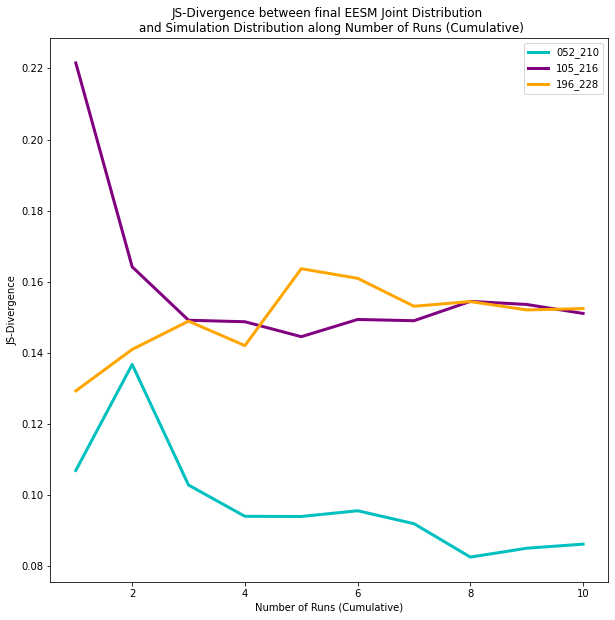

In [22]:
brer_1D_dict = {'052_210':{}, '105_216': {}, '196_228':{}}
brer_1D_dict['052_210'] = np.sum(brer_probs, axis =(1,2))
brer_1D_dict['105_216'] = np.sum(brer_probs, axis =(0,2))
brer_1D_dict['196_228'] = np.sum(brer_probs, axis =(0,1))
  
fig = plt.figure(figsize = (10,10))
waf.plot_js_along_runs(sim_data_1D_by_run, brer_1D_dict, "EESM")


In [42]:
!git init
!git config --global user.email "eeb7kw@virginia.edu"
!git config --global user.name "EmilyBoland"
!git remote add origin https://github.com/EmilyBoland/Syntaxin-EESM-Analysis.git
!git push -u origin master

Reinitialized existing Git repository in /content/drive/My Drive/.git/
fatal: remote origin already exists.


KeyboardInterrupt: ignored